## Part 1 - Cluster neighborhoods 

#### Import libraries

In [1]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

import numpy as np # library to handle data in a vectorized manner

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Import list of LA county communities with coordinates

In [2]:
!wget -q -O 'la_data.json' https://usc.data.socrata.com/api/views/9utn-waje/rows.json?accessType=DOWNLOAD


with open('la_data.json') as json_data:
    la_data = json.load(json_data)

    
# The data we need is found under 'data' in the json file
neighborhoods_data = la_data['data']


# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude']

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)



# extract neighborhood name, latitude and longitude from neighborhoods_data and save in df format
for data in neighborhoods_data:
    neighborhood_name = data[13]
        
    neighborhood_lat = float(data[20])
    neighborhood_lon = float(data[19])
    
    neighborhoods = neighborhoods.append({'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    

neighborhoods.head()

,Neighborhood,Latitude,Longitude
0,Acton,34.497355,-118.169810
1,Adams-Normandie,34.031461,-118.300208
2,Agoura Hills,34.146736,-118.759885
3,Agua Dulce,34.504927,-118.317104
4,Alhambra,34.085539,-118.136512


#### Get the coordinates of the City of Los Angeles

In [3]:
address = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536909, -118.2427666.


#### A map of LA and its neighborhoods

In [4]:
# create map of LA using latitude and longitude values
map_la = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
    
map_la

#### Combining several datasets from the NDSC to create one dataframe with information about each neighborhood

Get age distribution data

In [5]:
# read csv data
age_dist = pd.read_csv('Age_Distribution__LA_.csv')
# remove rows from previous years
age_dist = age_dist[age_dist['Year'] == 2016]
# remove columns
age_dist = age_dist[['Variable','Neighborhood','Percent']]
age_grouped = age_dist.groupby(['Variable','Neighborhood']).mean().reset_index()
age_grouped_pivot = age_grouped.pivot(index='Neighborhood', columns='Variable').reset_index()
age_grouped_pivot.columns = age_grouped_pivot.columns.droplevel(0)
age_grouped_pivot = age_grouped_pivot.reset_index()
age_grouped_pivot.drop(columns=['index'], inplace=True)
age_grouped_pivot.rename(columns={'':'Neighborhood'}, inplace=True)
age_grouped_pivot.head()

Variable,Neighborhood,Population Ages 18-24,Population Ages 25-34,Population Ages 35-44,Population Ages 45-54,Population Ages 55-64,Population Ages 65 & Older,Population Under Age 18
0,Acton,11.169902,8.469121,10.291287,18.860127,20.441956,14.097019,16.670589
1,Adams-Normandie,18.061678,15.167137,12.517903,12.066921,11.286173,8.616246,22.283943
2,Agoura Hills,7.354860,7.939531,13.327865,19.588894,15.061215,13.090613,23.637022
3,Agua Dulce,7.206238,10.943802,6.802904,18.822264,21.806938,16.617371,17.800484
4,Alhambra,9.096128,14.905549,13.560330,15.029588,13.316799,16.105332,17.986274


Get total number of population per neighborhood

In [6]:
# read csv data
population = pd.read_csv('Total_Population__LA_.csv')
population = population[population['Year'] == 2016]
population = population[['Neighborhood','Count']]
population.rename(columns={'Count':'Population'},inplace=True)
pop_group = population.groupby(['Neighborhood']).mean().reset_index()
pop_group.head()

,Neighborhood,Population
0,Acton,3885.5
1,Adams-Normandie,3506.4
2,Agoura Hills,6286.0
3,Agua Dulce,3719.0
4,Alhambra,4243.3


Get marital status

In [7]:
# read csv data
marit_status = pd.read_csv('Marital_Status__LA_.csv')
# remove old information
marit_status = marit_status[marit_status['Year'] == 2017]
marit_status = marit_status[['Variable','Percent','Neighborhood']]
# remove columns
marital_grouped = marit_status.groupby(['Variable','Neighborhood']).mean().reset_index()
marital_grouped_pivot = marital_grouped.pivot(index='Neighborhood', columns='Variable').reset_index()
marital_grouped_pivot.columns = marital_grouped_pivot.columns.droplevel(0)
marital_grouped_pivot = marital_grouped_pivot.reset_index()
marital_grouped_pivot.drop(columns=['index'], inplace=True)
marital_grouped_pivot.rename(columns={'':'Neighborhood'}, inplace=True)
marital_grouped_pivot.head()

Variable,Neighborhood,Divorced/Separated Population,Married Population,Never-Married Population,Widowed Population
0,Acton,8.500000,56.00,30.500000,5.000000
1,Adams-Normandie,11.600000,34.20,54.400000,4.000000
2,Agoura Hills,10.666667,57.00,30.666667,3.333333
3,Agua Dulce,9.000000,68.00,21.000000,4.000000
4,Alhambra,9.100000,47.45,38.700000,6.200000


Get average number of people per household

In [8]:
households = pd.read_csv('Households__LA_.csv')

households = households[households['Year'] == 2017]
households = households[households['Variable'] == 'Average Household Size']
households = households[['Variable','Count','Neighborhood']]

households_grouped = households.groupby(['Variable','Neighborhood']).mean().reset_index()
households_grouped_pivot = households_grouped.pivot(index='Neighborhood', columns='Variable').reset_index()
households_grouped_pivot.columns = households_grouped_pivot.columns.droplevel(0)
households_grouped_pivot = households_grouped_pivot.reset_index()
households_grouped_pivot.drop(columns=['index'], inplace=True)
households_grouped_pivot.rename(columns={'':'Neighborhood'}, inplace=True)
households_grouped_pivot.head()

Variable,Neighborhood,Average Household Size
0,Acton,2.855
1,Adams-Normandie,3.250
2,Agoura Hills,2.820
3,Agua Dulce,2.960
4,Alhambra,2.925


Get education information

In [9]:
edu_att = pd.read_csv('Educational_Attainment__LA_.csv')

edu_att = edu_att[edu_att['Year'] == 2017]
edu_att = edu_att[['Variable','Percent','Neighborhood']]

edu_grouped = edu_att.groupby(['Variable','Neighborhood']).mean().reset_index()
edu_grouped_pivot = edu_grouped.pivot(index='Neighborhood', columns='Variable').reset_index()
edu_grouped_pivot.columns = edu_grouped_pivot.columns.droplevel(0)
edu_grouped_pivot = edu_grouped_pivot.reset_index()
edu_grouped_pivot.drop(columns=['index'], inplace=True)
edu_grouped_pivot.rename(columns={'':'Neighborhood'}, inplace=True)
edu_grouped_pivot.head()

Variable,Neighborhood,College Graduation Rate,Less than High School,Young Adults Enrolled in School
0,Acton,24.760050,10.885392,42.990420
1,Adams-Normandie,17.561293,38.014641,54.191325
2,Agoura Hills,54.501554,4.713622,48.622389
3,Agua Dulce,26.909842,5.918789,46.416382
4,Alhambra,32.954648,18.867766,54.543256


Get unemployment rate

In [10]:
employment = pd.read_csv('Employment__LA_.csv')

employment = employment[employment['Year'] == 2017]
employment = employment[employment['Variable'] == 'Unemployment Rate']
employment = employment[['Variable','Percent','Neighborhood']]

employment_grouped = employment.groupby(['Variable','Neighborhood']).mean().reset_index()
employment_grouped_pivot = employment_grouped.pivot(index='Neighborhood', columns='Variable').reset_index()
employment_grouped_pivot.columns = employment_grouped_pivot.columns.droplevel(0)
employment_grouped_pivot = employment_grouped_pivot.reset_index()
employment_grouped_pivot.drop(columns=['index'], inplace=True)
employment_grouped_pivot.rename(columns={'':'Neighborhood'}, inplace=True)
employment_grouped_pivot.head()

Variable,Neighborhood,Unemployment Rate
0,Acton,11.454821
1,Adams-Normandie,13.797029
2,Agoura Hills,4.169422
3,Agua Dulce,4.942166
4,Alhambra,5.610108


Get crime rates

In [11]:
crimes = pd.read_csv('Part_I_Crimes__LA_.csv')

crimes = crimes[crimes['Year'] == 2016]
crimes = crimes[['Variable','Count','Neighborhood']]

crimes_grouped = crimes.groupby(['Variable','Neighborhood']).mean().reset_index()
crimes_grouped_pivot = crimes_grouped.pivot(index='Neighborhood', columns='Variable').reset_index()
crimes_grouped_pivot.columns = crimes_grouped_pivot.columns.droplevel(0)
crimes_grouped_pivot = crimes_grouped_pivot.reset_index()
crimes_grouped_pivot.drop(columns=['index'], inplace=True)
crimes_grouped_pivot.rename(columns={'':'Neighborhood'}, inplace=True)
crimes_grouped_pivot.rename(columns={'Part I Property Crimes':'Property Crimes Count Per 1000 People','Part I Violent Crimes':'Violent Crimes Count Per 1000 People' }, inplace=True)
crimes_grouped_pivot.head()

Variable,Neighborhood,Property Crimes Count Per 1000 People,Violent Crimes Count Per 1000 People
0,Acton,12.491046,1.647143
1,Adams-Normandie,20.134766,5.912570
2,Agoura Hills,13.465794,0.619836
3,Agua Dulce,5.646679,0.537779
4,Alondra Park,23.129526,3.620274


#### Combine all dfs to one dataframe

In [12]:
la_nbds = pd.merge(neighborhoods,age_grouped_pivot)
la_nbds = pd.merge(la_nbds,pop_group)
la_nbds = pd.merge(la_nbds,marital_grouped_pivot)
la_nbds = pd.merge(la_nbds,households_grouped_pivot)
la_nbds = pd.merge(la_nbds,edu_grouped_pivot)
la_nbds = pd.merge(la_nbds,employment_grouped_pivot)
la_nbds = pd.merge(la_nbds,crimes_grouped_pivot)

la_nbds.head()


,Neighborhood,Latitude,Longitude,Population Ages 18-24,Population Ages 25-34,Population Ages 35-44,Population Ages 45-54,Population Ages 55-64,Population Ages 65 & Older,Population Under Age 18,Population,Divorced/Separated Population,Married Population,Never-Married Population,Widowed Population,Average Household Size,College Graduation Rate,Less than High School,Young Adults Enrolled in School,Unemployment Rate,Property Crimes Count Per 1000 People,Violent Crimes Count Per 1000 People
0,Acton,34.497355,-118.169810,11.169902,8.469121,10.291287,18.860127,20.441956,14.097019,16.670589,3885.5,8.500000,56.0,30.500000,5.000000,2.855,24.760050,10.885392,42.990420,11.454821,12.491046,1.647143
1,Adams-Normandie,34.031461,-118.300208,18.061678,15.167137,12.517903,12.066921,11.286173,8.616246,22.283943,3506.4,11.600000,34.2,54.400000,4.000000,3.250,17.561293,38.014641,54.191325,13.797029,20.134766,5.912570
2,Agoura Hills,34.146736,-118.759885,7.354860,7.939531,13.327865,19.588894,15.061215,13.090613,23.637022,6286.0,10.666667,57.0,30.666667,3.333333,2.820,54.501554,4.713622,48.622389,4.169422,13.465794,0.619836
3,Agua Dulce,34.504927,-118.317104,7.206238,10.943802,6.802904,18.822264,21.806938,16.617371,17.800484,3719.0,9.000000,68.0,21.000000,4.000000,2.960,26.909842,5.918789,46.416382,4.942166,5.646679,0.537779
4,Alondra Park,33.889617,-118.335156,7.542236,13.515688,13.334674,15.567176,10.498794,18.986324,20.555109,4972.0,14.000000,44.0,37.000000,8.000000,3.120,34.261917,9.276277,38.104839,9.914321,23.129526,3.620274


In [13]:
rows, cols = la_nbds.shape
print('Table contains ', rows,' neighborhoods')
print('Table contains ',cols - 3,' features')

Table contains  226  neighborhoods
Table contains  19  features


Remove NaN values

In [14]:
la_nbds.isnull().sum()

Neighborhood                             0
Latitude                                 0
Longitude                                0
Population Ages 18-24                    3
Population Ages 25-34                    3
Population Ages 35-44                    3
Population Ages 45-54                    3
Population Ages 55-64                    3
Population Ages 65 & Older               3
Population Under Age 18                  3
Population                               3
Divorced/Separated Population            3
Married Population                       3
Never-Married Population                 3
Widowed Population                       3
Average Household Size                   2
College Graduation Rate                  3
Less than High School                    3
Young Adults Enrolled in School          5
Unemployment Rate                        3
Property Crimes Count Per 1000 People    3
Violent Crimes Count Per 1000 People     3
dtype: int64

In [15]:
# Remove nans
la_nbds = la_nbds.dropna()
rows, cols = la_nbds.shape
print('The new table contains ', rows,' neighborhoods')
print('The new table contains ',cols - 3,' features')

The new table contains  220  neighborhoods
The new table contains  19  features


#### Cluster Neighborhoods

In [16]:
# set number of clusters
kclusters = 6

la_nbds_clustering = la_nbds.drop(['Neighborhood','Latitude','Longitude'], 1) # remove name and coordinates

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_nbds_clustering)

# add clustering labels
la_nbds['Cluster Labels'] = kmeans.labels_

la_nbds.head()

,Neighborhood,Latitude,Longitude,Population Ages 18-24,Population Ages 25-34,Population Ages 35-44,Population Ages 45-54,Population Ages 55-64,Population Ages 65 & Older,Population Under Age 18,Population,Divorced/Separated Population,Married Population,Never-Married Population,Widowed Population,Average Household Size,College Graduation Rate,Less than High School,Young Adults Enrolled in School,Unemployment Rate,Property Crimes Count Per 1000 People,Violent Crimes Count Per 1000 People,Cluster Labels
0,Acton,34.497355,-118.169810,11.169902,8.469121,10.291287,18.860127,20.441956,14.097019,16.670589,3885.5,8.500000,56.0,30.500000,5.000000,2.855,24.760050,10.885392,42.990420,11.454821,12.491046,1.647143,5
1,Adams-Normandie,34.031461,-118.300208,18.061678,15.167137,12.517903,12.066921,11.286173,8.616246,22.283943,3506.4,11.600000,34.2,54.400000,4.000000,3.250,17.561293,38.014641,54.191325,13.797029,20.134766,5.912570,0
2,Agoura Hills,34.146736,-118.759885,7.354860,7.939531,13.327865,19.588894,15.061215,13.090613,23.637022,6286.0,10.666667,57.0,30.666667,3.333333,2.820,54.501554,4.713622,48.622389,4.169422,13.465794,0.619836,4
3,Agua Dulce,34.504927,-118.317104,7.206238,10.943802,6.802904,18.822264,21.806938,16.617371,17.800484,3719.0,9.000000,68.0,21.000000,4.000000,2.960,26.909842,5.918789,46.416382,4.942166,5.646679,0.537779,0
4,Alondra Park,33.889617,-118.335156,7.542236,13.515688,13.334674,15.567176,10.498794,18.986324,20.555109,4972.0,14.000000,44.0,37.000000,8.000000,3.120,34.261917,9.276277,38.104839,9.914321,23.129526,3.620274,2


Display the number of neighborhoods in each cluster

In [17]:
clusters = la_nbds['Cluster Labels'].value_counts().rename_axis('unique_values').to_frame('counts')
clusters

,counts
unique_values,
5,76
2,66
0,53
1,13
4,11
3,1


Map Clusters

In [18]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_nbds['Latitude'], la_nbds['Longitude'], la_nbds['Neighborhood'], la_nbds['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Compare Clusters

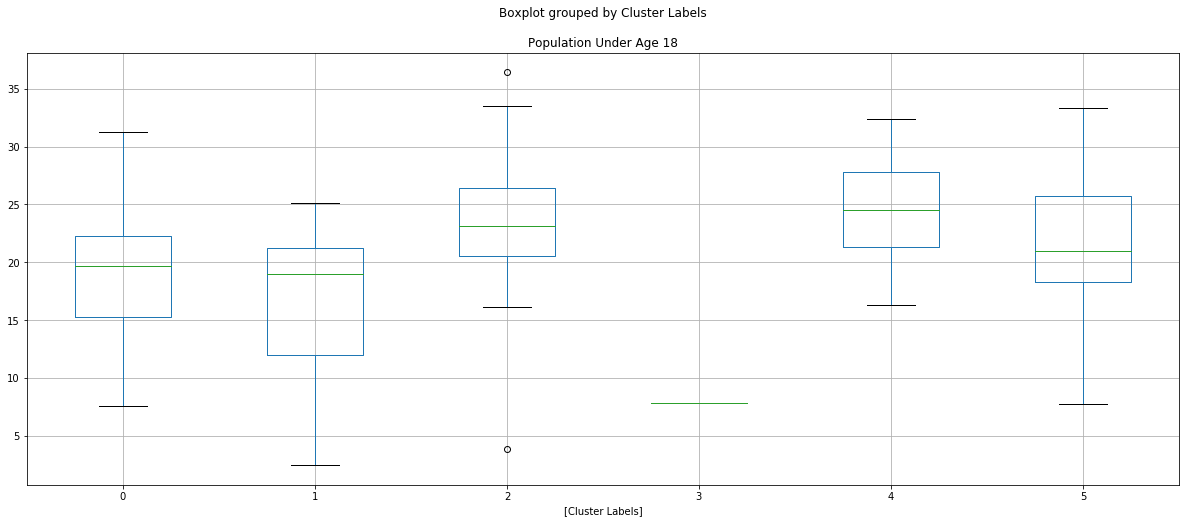

In [19]:
boxplot = la_nbds.boxplot(column=['Population Under Age 18'], by=['Cluster Labels'], figsize=(20,8))

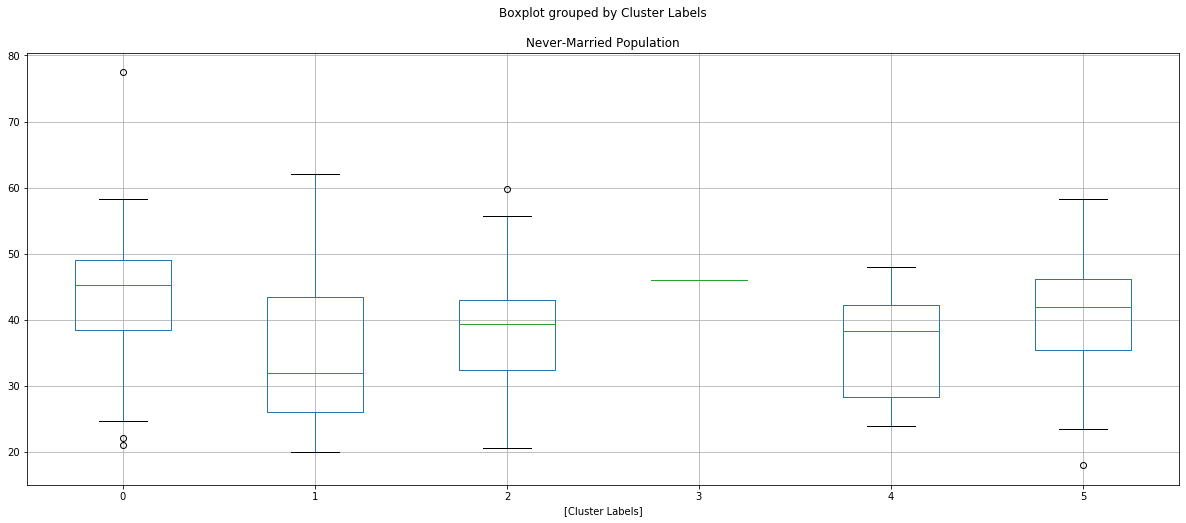

In [20]:
boxplot = la_nbds.boxplot(column=['Never-Married Population'], by=['Cluster Labels'], figsize=(20,8))

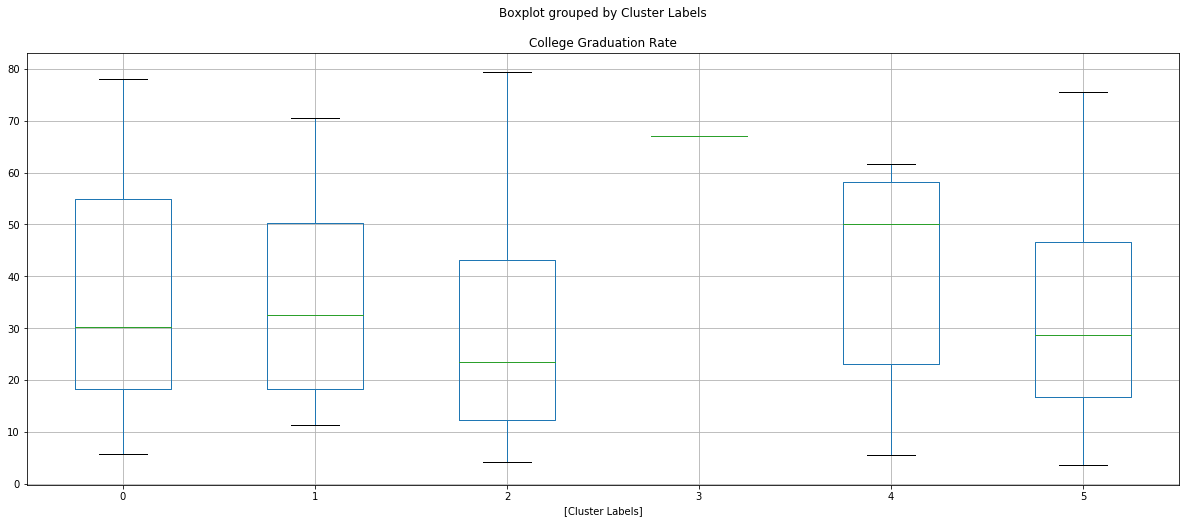

In [21]:
boxplot = la_nbds.boxplot(column=['College Graduation Rate'], by=['Cluster Labels'], figsize=(20,8))

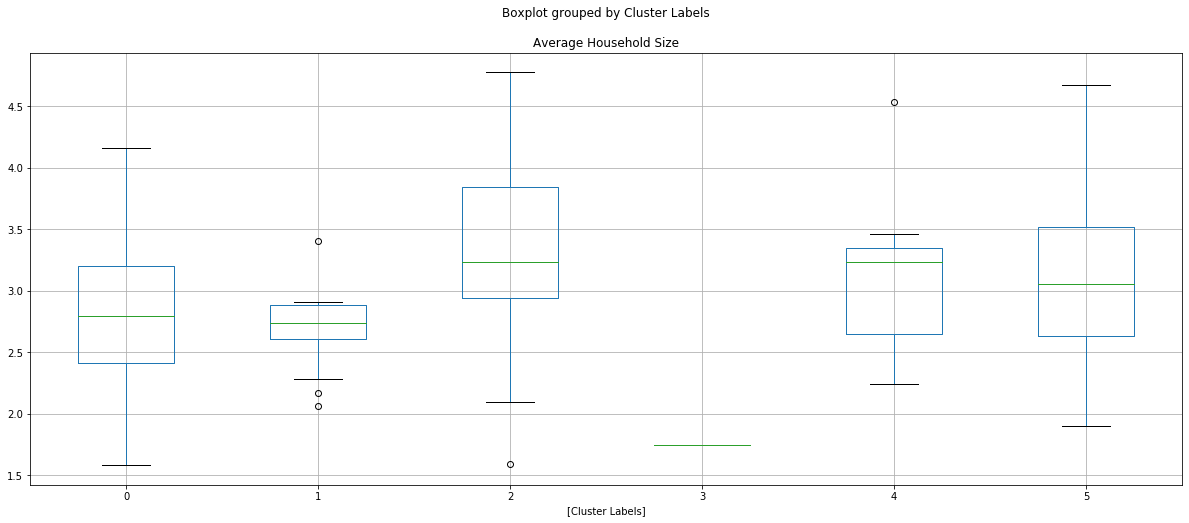

In [22]:
boxplot = la_nbds.boxplot(column=['Average Household Size'], by=['Cluster Labels'], figsize=(20,8))

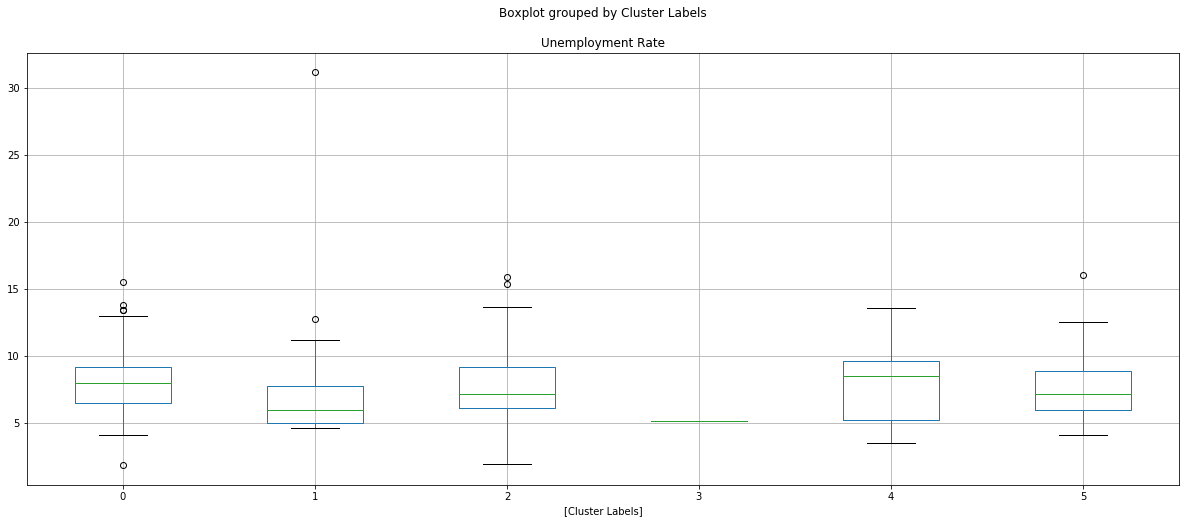

In [23]:
boxplot = la_nbds.boxplot(column=['Unemployment Rate'], by=['Cluster Labels'], figsize=(20,8))

In [24]:
cluster_mean = pd.DataFrame(la_nbds[la_nbds['Cluster Labels'] == 0].mean())
cluster_mean['1'] = pd.DataFrame(la_nbds[la_nbds['Cluster Labels'] == 1].mean())
cluster_mean['2'] = pd.DataFrame(la_nbds[la_nbds['Cluster Labels'] == 2].mean())
cluster_mean['3'] = pd.DataFrame(la_nbds[la_nbds['Cluster Labels'] == 3].mean())
cluster_mean['4'] = pd.DataFrame(la_nbds[la_nbds['Cluster Labels'] == 4].mean())
cluster_mean['5'] = pd.DataFrame(la_nbds[la_nbds['Cluster Labels'] == 5].mean())
cluster_mean 

,0,1,2,3,4,5
Latitude,34.079499,34.127273,34.065411,33.975324,34.129191,34.098553
Longitude,-118.303464,-118.291647,-118.206863,-118.447869,-118.340102,-118.314324
Population Ages 18-24,9.807841,8.321854,9.721387,7.963607,8.294216,10.185861
Population Ages 25-34,17.276146,10.794044,13.695357,24.493969,12.275958,15.310315
Population Ages 35-44,14.375307,11.559610,13.229671,19.883459,13.420844,13.639576
Population Ages 45-54,13.896399,17.492178,14.456244,11.827847,15.538783,14.239887
Population Ages 55-64,12.197921,16.838039,11.954032,15.508076,13.195457,11.844661
Population Ages 65 & Older,13.297869,18.355859,13.371896,12.471888,12.921704,12.937880
Population Under Age 18,19.148517,16.638415,23.571412,7.851155,24.353037,21.841818
Population,3454.588881,1473.192308,5028.554544,9782.000000,6251.111570,4133.566198


## Part 2 - Cluster according to venues

## Create a new dataframe with venues categories for all the neighborhoods in clusters 3,4 and 5

Focusing on clusters no. 3, 0 and 5

In [25]:
la_nbds_4 = la_nbds[(la_nbds['Cluster Labels'] == 3) | (la_nbds['Cluster Labels'] == 0) | (la_nbds['Cluster Labels'] == 5)]
la_nbds_4.head()

,Neighborhood,Latitude,Longitude,Population Ages 18-24,Population Ages 25-34,Population Ages 35-44,Population Ages 45-54,Population Ages 55-64,Population Ages 65 & Older,Population Under Age 18,Population,Divorced/Separated Population,Married Population,Never-Married Population,Widowed Population,Average Household Size,College Graduation Rate,Less than High School,Young Adults Enrolled in School,Unemployment Rate,Property Crimes Count Per 1000 People,Violent Crimes Count Per 1000 People,Cluster Labels
0,Acton,34.497355,-118.169810,11.169902,8.469121,10.291287,18.860127,20.441956,14.097019,16.670589,3885.5,8.5,56.000000,30.500000,5.000000,2.855,24.760050,10.885392,42.990420,11.454821,12.491046,1.647143,5
1,Adams-Normandie,34.031461,-118.300208,18.061678,15.167137,12.517903,12.066921,11.286173,8.616246,22.283943,3506.4,11.6,34.200000,54.400000,4.000000,3.250,17.561293,38.014641,54.191325,13.797029,20.134766,5.912570,0
3,Agua Dulce,34.504927,-118.317104,7.206238,10.943802,6.802904,18.822264,21.806938,16.617371,17.800484,3719.0,9.0,68.000000,21.000000,4.000000,2.960,26.909842,5.918789,46.416382,4.942166,5.646679,0.537779,0
10,Arlington Heights,34.044910,-118.323408,9.266111,17.129554,16.294708,13.064763,10.203373,10.562602,23.478890,3913.0,12.0,40.666667,46.833333,3.666667,3.160,23.832302,31.413585,44.032868,7.979365,18.416043,5.215334,5
11,Athens,33.923693,-118.304656,13.883212,15.543963,12.375528,16.620634,8.549219,13.245852,19.781596,3642.0,12.0,41.000000,45.500000,5.500000,3.145,12.612178,26.897538,46.069508,12.979957,35.040742,19.644185,0


Taking only Name, Latitude and Longitude

In [26]:
nbds = la_nbds_4[['Neighborhood','Latitude','Longitude']].reset_index()
nbds.drop(['index'], axis=1, inplace=True)
nbds.head()

,Neighborhood,Latitude,Longitude
0,Acton,34.497355,-118.169810
1,Adams-Normandie,34.031461,-118.300208
2,Agua Dulce,34.504927,-118.317104
3,Arlington Heights,34.044910,-118.323408
4,Athens,33.923693,-118.304656


Define Foursquare Credentials

In [27]:
# @hidden_cell

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Create a function that returns venues per neighborhood (in a radius of 500 m)

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Use the function above to create a new dataframe that contains all LA neighborhoods, venues, category and coordinates

In [29]:
la_venues = getNearbyVenues(names=nbds['Neighborhood'],
                                   latitudes=nbds['Latitude'],
                                   longitudes=nbds['Longitude']
                                  )
la_venues.head()

Acton
Adams-Normandie
Agua Dulce
Arlington Heights
Athens
Atwater Village
Avalon
Vermont-Slauson
Baldwin Hills/Crenshaw
Bellflower
Beverly Crest
Beverly Grove
Koreatown
Beverlywood
Boyle Heights
Brentwood
Calabasas
Canoga Park
Carthay
Castaic Canyons
Chatsworth
Castaic
Central-Alameda
Cerritos
Chinatown
Northridge
Commerce
Cypress Park
Del Rey
Downtown
Eagle Rock
East Compton
East Hollywood
East Los Angeles
Echo Park
El Sereno
Elysian Valley
Fairfax
Florence
Gardena
Glassell Park
Vermont Vista
Granada Hills
Hacienda Heights
Hancock Park
Harbor City
Harvard Heights
Harvard Park
Walnut Park
Mar Vista
Highland Park
Historic South-Central
Hollywood Hills
Hollywood Hills West
Hollywood
Huntington Park
Hyde Park
Jefferson Park
Industry
Lake Balboa
Lake View Terrace
Larchmont
Leimert Park
Lennox
Leona Valley
Lincoln Heights
Lomita
Long Beach
Lopez/Kagel Canyons
Los Feliz
Manchester Square
Marina del Rey
Mayflower Village
Mid-City
Mid-Wilshire
Mission Hills
West Adams
Montecito Heights
Mount W

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Acton,34.497355,-118.169810,Epik Engineering,34.498718,-118.168046,Construction & Landscaping
1,Acton,34.497355,-118.169810,Alma Gardening Co.,34.494762,-118.172550,Construction & Landscaping
2,Adams-Normandie,34.031461,-118.300208,Orange Door Sushi,34.032485,-118.299368,Sushi Restaurant
3,Adams-Normandie,34.031461,-118.300208,Shell,34.033095,-118.300025,Gas Station
4,Adams-Normandie,34.031461,-118.300208,Sushi Delight,34.032445,-118.299525,Sushi Restaurant


Display how many venues per neighborhood

In [30]:
la_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Acton,2,2,2,2,2,2
Adams-Normandie,10,10,10,10,10,10
Agua Dulce,1,1,1,1,1,1
Arlington Heights,30,30,30,30,30,30
Atwater Village,22,22,22,22,22,22
Avalon,4,4,4,4,4,4
Baldwin Hills/Crenshaw,2,2,2,2,2,2
Bellflower,15,15,15,15,15,15
Beverly Crest,1,1,1,1,1,1


In [31]:
print('There are {} uniques categories.'.format(len(la_venues['Venue Category'].unique())))

There are 256 uniques categories.


In [32]:
# refind category list
venue_category = ['Fast Food Restaurant',
       'Indian Restaurant', 'Sushi Restaurant', 'Bakery',
       'Café', 'Breakfast Spot', 'Restaurant', 'BBQ Joint', 'Brewery',
       'American Restaurant', 'Multiplex', 'Burger Joint',
       'Thai Restaurant', 'Deli / Bodega', 'Chinese Restaurant', 'Lounge',
       'Mexican Restaurant', 'Hotel',
       'Diner', 'Nightclub', 'Latin American Restaurant',
       'Fried Chicken Joint', 'Music Venue',
       'Vegetarian / Vegan Restaurant', 'Karaoke Bar',
       'Convenience Store', 'Donut Shop', 'Korean Restaurant',
       'Liquor Store', 'Food',
       'Seafood Restaurant', 'Bus Station',
       'Clothing Store', 'Sandwich Place',
       'Video Game Store',
       'Pizza Place', 'Park', 'Food Truck', 'Boutique', 'Historic Site',
       'Bagel Shop', 'Ice Cream Shop', 'Sports Bar', 'Cosmetics Shop',
       'Ethiopian Restaurant',
       'Video Store', 'Movie Theater', 'Yoga Studio',
       'Board Shop', 'Thrift / Vintage Store', 'Theater',
       'Kitchen Supply Store', 'Performing Arts Venue', 'Moving Target',
       'French Restaurant', 'Bar', 'Plaza', 'Filipino Restaurant',
       'Coffee Shop', 'Cajun / Creole Restaurant',
       'Vietnamese Restaurant', 'Bubble Tea Shop', 'Monument / Landmark',
       'Taiwanese Restaurant', 'Dim Sum Restaurant', 'Jazz Club',
       'Art Gallery', 'Recreation Center', 'Tea Room', 'Shopping Mall',
       'Japanese Restaurant', 'College Theater', 'Hot Dog Joint', 'Pub',
       'Gym', 'Juice Bar', 'Taco Place', 'Music Store',
       'Pet Store', 'Smoke Shop', 'Hobby Shop',
       'Middle Eastern Restaurant', 'Mediterranean Restaurant',
       'Falafel Restaurant', 'Southern / Soul Food Restaurant', 'Bookstore', 'Wine Bar',
       'Rock Club', 'Health Food Store', 'Toy / Game Store',
       'Farmers Market', 'Art Museum', 'Indie Movie Theater',
       'Noodle House', 'Italian Restaurant', 'Ramen Restaurant',
       'Market','Dessert Shop', 'Spa', 'Creperie',
       'Dumpling Restaurant', 'Scenic Lookout',
       'New American Restaurant', 'Asian Restaurant',
       'Racetrack', 'Trail', 'Dog Run', 'Cycle Studio', 'Gastropub',
       'Gym / Fitness Center', 'Hawaiian Restaurant','Gym Pool',
       'Steakhouse','Argentinian Restaurant',
       'Dance Studio', 'Playground', 'Sporting Goods Shop',
       'Surf Spot','Harbor / Marina', 'Boat or Ferry', 'Pool', 'Beach',
       'Baseball Field', 'Sake Bar', 'River',
       'Skating Rink', 'Indonesian Restaurant',
       'Kosher Restaurant','Pier', 'Dive Bar',
       'Food & Drink Shop', 'Martial Arts Dojo',
       'Massage Studio', 'Pet Service', 'Tiki Bar',
       'Poke Place', 'Social Club',
       'Frozen Yogurt Shop', 'Arts & Crafts Store',
       'Eastern European Restaurant', 'Wings Joint', 'Smoothie Shop',
       'Soup Place', 'General Entertainment',
       'Garden', 'Donburi Restaurant', 'Food Court',
       'Concert Hall']
la_venues = la_venues[la_venues['Venue Category'].isin(venue_category)]
la_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Adams-Normandie,34.031461,-118.300208,Orange Door Sushi,34.032485,-118.299368,Sushi Restaurant
4,Adams-Normandie,34.031461,-118.300208,Sushi Delight,34.032445,-118.299525,Sushi Restaurant
5,Adams-Normandie,34.031461,-118.300208,Little Xian,34.032292,-118.299465,Sushi Restaurant
6,Adams-Normandie,34.031461,-118.300208,Tacos La Estrella,34.032230,-118.300757,Taco Place
8,Adams-Normandie,34.031461,-118.300208,Loren Miller Recreational Park,34.031335,-118.303717,Playground


Use one hot encoding to analyze each neighborhood by venue category

In [33]:
# one hot encoding
la_onehot = pd.get_dummies(la_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
la_onehot.insert(0, 'Neighborhood', la_venues['Neighborhood'], True )
la_onehot = la_onehot.loc[:, ~la_onehot.columns.duplicated()] # remove duplicate columns

# group by neighborhood
la_grouped = la_onehot.groupby('Neighborhood').mean().reset_index()

la_grouped.head()


,Neighborhood,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Board Shop,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Café,Cajun / Creole Restaurant,Chinese Restaurant,Clothing Store,Coffee Shop,College Theater,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Garden,Gastropub,General Entertainment,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,Historic Site,Hobby Shop,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Moving Target,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Park,Performing Arts Venue,Pet Service,Pet Store,Pier,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Racetrack,Ramen Restaurant,Recreation Center,Restaurant,River,Rock Club,Sake Bar,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Soup Place,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,Adams-Normandie,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.166667,0.0,0.0,0.0,0.0,0.000000,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,Arlington Heights,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.04,0.0,0.04,0.0,0.000000,0.0,0.0,0.04,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.04,0.000000,0.0,0.0,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.08,0.08,0.0,0.08,0.04,0.0,0.0,0.0,0.0,0.000000,0.080000,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.04,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.0,0.0
2,Atwater Village,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.076923,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.00,0.076923,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.076923,0.076923,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.076923,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.

Create a dataframe with the top 10 venues per neighborhood

In [34]:
# This function returns the top number of categories 
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = la_grouped['Neighborhood']

for ind in np.arange(la_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(la_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams-Normandie,Sushi Restaurant,Taco Place,Playground,Park,Yoga Studio,Falafel Restaurant,Food,Filipino Restaurant,Fast Food Restaurant,Farmers Market
1,Arlington Heights,Donut Shop,Vegetarian / Vegan Restaurant,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Sushi Restaurant,Dance Studio,Nightclub,Convenience Store
2,Atwater Village,Taco Place,Fried Chicken Joint,Ice Cream Shop,Juice Bar,Food Court,Pizza Place,Mexican Restaurant,Bakery,Bar,Mediterranean Restaurant
3,Avalon,American Restaurant,Mexican Restaurant,Playground,Farmers Market,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
4,Baldwin Hills/Crenshaw,Park,Clothing Store,Yoga Studio,Diner,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Farmers Market


#### Cluster according to venues

Running k-means to cluster neighborhoods, and creating a df combining tor_nbds df and neighborhoods_venues_sorted df

In [36]:
# set number of clusters
kclusters = 5

la_grouped_clustering = la_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_grouped_clustering)

# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_

la_merged = nbds

# merge la_grouped with la_data to add latitude/longitude for each neighborhood
la_merged = la_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

la_merged = la_merged.dropna()
la_merged.reset_index(drop=True)

la_merged['Cluster Labels'] = la_merged['Cluster Labels'].astype('int64') 
la_merged.head() 

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,Adams-Normandie,34.031461,-118.300208,Sushi Restaurant,Taco Place,Playground,Park,Yoga Studio,Falafel Restaurant,Food,Filipino Restaurant,Fast Food Restaurant,Farmers Market,3
3,Arlington Heights,34.044910,-118.323408,Donut Shop,Vegetarian / Vegan Restaurant,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Sushi Restaurant,Dance Studio,Nightclub,Convenience Store,3
5,Atwater Village,34.131066,-118.262373,Taco Place,Fried Chicken Joint,Ice Cream Shop,Juice Bar,Food Court,Pizza Place,Mexican Restaurant,Bakery,Bar,Mediterranean Restaurant,3
6,Avalon,33.336954,-118.327332,American Restaurant,Mexican Restaurant,Playground,Farmers Market,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,3
7,Vermont-Slauson,33.983914,-118.290358,Burger Joint,Chinese Restaurant,Clothing Store,Sandwich Place,Fast Food Restaurant,Food Truck,Food Court,Food,Filipino Restaurant,Yoga Studio,3


How many neighborhoods in each cluster

In [37]:
clusters = la_merged['Cluster Labels'].value_counts().rename_axis('unique_values').to_frame('counts')
clusters

,counts
unique_values,
3,88
1,10
4,8
2,7
0,1


Map Clusters

In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_merged['Latitude'], la_merged['Longitude'], la_merged['Neighborhood'], la_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [39]:
la_merged[la_merged['Cluster Labels'] == 0]

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
15,Brentwood,34.086241,-118.492189,Café,Yoga Studio,Farmers Market,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Fried Chicken Joint,0


In [40]:
la_merged[la_merged['Cluster Labels'] == 1]

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
8,Baldwin Hills/Crenshaw,34.011970,-118.357746,Park,Clothing Store,Yoga Studio,Diner,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Farmers Market,1
22,Central-Alameda,34.006864,-118.247213,Donut Shop,Mexican Restaurant,Park,Yoga Studio,Fast Food Restaurant,Food Truck,Food Court,Food,Filipino Restaurant,Farmers Market,1
27,Cypress Park,34.092139,-118.224156,Bakery,Mexican Restaurant,Park,Farmers Market,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Yoga Studio,1
33,East Los Angeles,34.035169,-118.159638,Mexican Restaurant,Park,Southern / Soul Food Restaurant,Coffee Shop,Deli / Bodega,Sushi Restaurant,Cosmetics Shop,Latin American Restaurant,Fast Food Restaurant,Food Court,1
45,Harbor City,33.797697,-118.295164,Food,Mexican Restaurant,Park,Yoga Studio,Fried Chicken Joint,Food Truck,Food Court,Filipino Restaurant,Fast Food Restaurant,Farmers Market,1
55,Huntington Park,33.978967,-118.214015,Fried Chicken Joint,Burger Joint,Park,Diner,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Farmers Market,1
57,Jefferson Park,34.028211,-118.322059,Park,Fried Chicken Joint,Taco Place,Mexican Restaurant,Convenience Store,Sandwich Place,Farmers Market,Food,Filipino Restaurant,Fast Food Restaurant,1
63,Lennox,33.938174,-118.357147,Mexican Restaurant,Taco Place,Convenience Store,Pizza Place,Park,Yoga Studio,Farmers Market,Food,Filipino Restaurant,Fast Food Restaurant,1
86,Panorama City,34.229503,-118.445216,Mexican Restaurant,Park,Skating Rink,Yoga Studio,French Restaurant,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Farmers Market,1
106,South El Monte,34.048729,-118.048532,Park,Mexican Restaurant,Convenience Store,Yoga Studio,Farmers Market,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,1


In [41]:
la_merged[la_merged['Cluster Labels'] == 2]

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
20,Chatsworth,34.256403,-118.612355,Park,Yoga Studio,Farmers Market,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Fried Chicken Joint,2
43,Hacienda Heights,34.002086,-117.975081,Park,Yoga Studio,Farmers Market,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Fried Chicken Joint,2
47,Harvard Park,33.983763,-118.304558,Park,Yoga Studio,Farmers Market,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Fried Chicken Joint,2
75,Mission Hills,34.271661,-118.457163,Park,Yoga Studio,Farmers Market,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Fried Chicken Joint,2
77,Montecito Heights,34.093659,-118.194270,Park,Yoga Studio,Farmers Market,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Fried Chicken Joint,2
92,Porter Ranch,34.278216,-118.548730,Park,Yoga Studio,Farmers Market,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Fried Chicken Joint,2
126,Whittier Narrows,34.037074,-118.061188,Park,Yoga Studio,Farmers Market,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Fried Chicken Joint,2


In [42]:
la_merged[la_merged['Cluster Labels'] == 3]

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,Adams-Normandie,34.031461,-118.300208,Sushi Restaurant,Taco Place,Playground,Park,Yoga Studio,Falafel Restaurant,Food,Filipino Restaurant,Fast Food Restaurant,Farmers Market,3
3,Arlington Heights,34.044910,-118.323408,Donut Shop,Vegetarian / Vegan Restaurant,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Sushi Restaurant,Dance Studio,Nightclub,Convenience Store,3
5,Atwater Village,34.131066,-118.262373,Taco Place,Fried Chicken Joint,Ice Cream Shop,Juice Bar,Food Court,Pizza Place,Mexican Restaurant,Bakery,Bar,Mediterranean Restaurant,3
6,Avalon,33.336954,-118.327332,American Restaurant,Mexican Restaurant,Playground,Farmers Market,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,3
7,Vermont-Slauson,33.983914,-118.290358,Burger Joint,Chinese Restaurant,Clothing Store,Sandwich Place,Fast Food Restaurant,Food Truck,Food Court,Food,Filipino Restaurant,Yoga Studio,3
9,Bellflower,33.888013,-118.129032,Pizza Place,Mexican Restaurant,Sandwich Place,Burger Joint,Donburi Restaurant,Video Game Store,Chinese Restaurant,Fast Food Restaurant,Farmers Market,Food Court,3
10,Beverly Crest,34.106007,-118.423263,Juice Bar,Yoga Studio,Farmers Market,French Restaurant,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,3
11,Beverly Grove,34.076633,-118.376102,Clothing Store,Boutique,Cosmetics Shop,Seafood Restaurant,Gym / Fitness Center,Juice Bar,Mexican Restaurant,Bakery,Italian Restaurant,Sandwich Place,3
12,Koreatown,34.064510,-118.304958,Korean Restaurant,Café,Hotel,Burger Joint,Karaoke Bar,Sushi Restaurant,Coffee Shop,Restaurant,Bakery,Asian Restaurant,3
13,Beverlywood,34.043510,-118.393982,Dessert Shop,Food Truck,Boutique,Hotel,Park,Yoga Studio,Fast Food Restaurant,Food Court,Food,Filipino Restaurant,3


In [43]:
la_merged[la_merged['Cluster Labels'] == 4]

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
36,Elysian Valley,34.095759,-118.241957,Trail,Gym / Fitness Center,Rock Club,Park,Seafood Restaurant,Yoga Studio,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,4
52,Hollywood Hills,34.128089,-118.335410,Scenic Lookout,Bus Station,Trail,Park,Falafel Restaurant,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Farmers Market,4
58,Industry,34.026836,-117.939621,Racetrack,Trail,Ethiopian Restaurant,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Eastern European Restaurant,4
78,Mount Washington,34.103159,-118.219007,Trail,Garden,Park,Yoga Studio,Falafel Restaurant,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Farmers Market,4
105,Silver Lake,34.094459,-118.267708,Trail,Thai Restaurant,Recreation Center,Dog Run,Historic Site,Yoga Studio,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,4
112,Tujunga,34.261340,-118.281800,Trail,Yoga Studio,Falafel Restaurant,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Ethiopian Restaurant,4
116,Unincorporated Santa Monica Mountains,34.087646,-118.770268,Trail,Yoga Studio,Falafel Restaurant,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Ethiopian Restaurant,4
121,Walnut,34.033248,-117.860126,Scenic Lookout,Yoga Studio,Falafel Restaurant,Food Truck,Food Court,Food,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Ethiopian Restaurant,4


In [44]:
la_grouped['Cluster Labels'] = kmeans.labels_

In [45]:
la_grouped.head()

,Neighborhood,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Board Shop,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Café,Cajun / Creole Restaurant,Chinese Restaurant,Clothing Store,Coffee Shop,College Theater,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Garden,Gastropub,General Entertainment,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,Historic Site,Hobby Shop,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Moving Target,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Park,Performing Arts Venue,Pet Service,Pet Store,Pier,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Racetrack,Ramen Restaurant,Recreation Center,Restaurant,River,Rock Club,Sake Bar,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Soup Place,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio,Cluster Labels
0,Adams-Normandie,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.166667,0.0,0.0,0.0,0.0,0.000000,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,3
1,Arlington Heights,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.04,0.0,0.04,0.0,0.000000,0.0,0.0,0.04,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.04,0.000000,0.0,0.0,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.08,0.08,0.0,0.08,0.04,0.0,0.0,0.0,0.0,0.000000,0.080000,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.04,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.0,0.0,3
2,Atwater Village,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.076923,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.00,0.076923,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.076923,0.076923,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.076923,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.153846,0.0,0.0,0.0,0.0,0.0,

Create a new df where each row is the sum of all values of venues in a cluster

In [68]:
la_nbds_c0 = la_grouped[la_grouped['Cluster Labels'] == 0]
la_nbds_c1 = la_grouped[la_grouped['Cluster Labels'] == 1]
la_nbds_c2 = la_grouped[la_grouped['Cluster Labels'] == 2]
la_nbds_c3 = la_grouped[la_grouped['Cluster Labels'] == 3]
la_nbds_c4 = la_grouped[la_grouped['Cluster Labels'] == 4]

tmp0 = pd.DataFrame(la_nbds_c0.sum(axis=0)).T
tmp0['Neighborhood'] = '0'   
tmp1 = pd.DataFrame(la_nbds_c1.sum(axis=0)).T
tmp1['Neighborhood'] = '1'   
tmp2 = pd.DataFrame(la_nbds_c2.sum(axis=0)).T
tmp2['Neighborhood'] = '2'   
tmp3 = pd.DataFrame(la_nbds_c3.sum(axis=0)).T
tmp3['Neighborhood'] = '3'   
tmp4 = pd.DataFrame(la_nbds_c4.sum(axis=0)).T
tmp4['Neighborhood'] = '4'   

clusters_grouped = pd.concat([pd.concat([pd.concat([pd.concat([tmp0, tmp1], ignore_index=True),tmp2], ignore_index=True),tmp3], ignore_index=True),tmp4], ignore_index=True)
clusters_grouped.rename(columns={"Neighborhood": "Cluster"}, inplace=True)
clusters_grouped.drop(['Cluster Labels'], axis=1, inplace=True)
clusters_grouped.head()


,Cluster,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Board Shop,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Café,Cajun / Creole Restaurant,Chinese Restaurant,Clothing Store,Coffee Shop,College Theater,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Garden,Gastropub,General Entertainment,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,Historic Site,Hobby Shop,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Moving Target,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Park,Performing Arts Venue,Pet Service,Pet Store,Pier,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Racetrack,Ramen Restaurant,Recreation Center,Restaurant,River,Rock Club,Sake Bar,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Soup Place,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0.333333,0,0,0,0,0,0,0,0,0,0,0.333333,0,0,0,0,0.5,0.0833333,0,0,0.67619,0.0833333,0,0,0.0833333,0,0,0,0,0,0,0.333333,0,0,0,0,0,0.0833333,0,0.333333,0,0,0,0.47619,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0833333,0,0,0,0,0,0,2.45952,0,0,0,0,0,0,0,0,0,3.05238,0,0,0,0,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0.142857,0,0,0,0.333333,0,0,0,0.0833333,0,0,0,0,0,0.0833333,0.342857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1.65491,0.04,1.18554,0.0285714,0.329604,0.96297,0.0890597,0.056891,2.56987,0.617296,0.45,0.366667,0.333333,0.416667,1.11395,0.446392,0.696918,0.0222222,0.163426,2.59413,0.229145,2.2715,0.0834988,1.26566,1.09868,3.02588,0.143541,0.315152,3.73124,0.992029,0.0212766,0.132546,0.844265,0.365422,0.0222222,0.321278,0.220614,0.333333,0.143541,2.5172,0.0418623,0.0769231,0.454212,0.115385,0.243307,3.1815,0.0222222,1.05786,0.0769231,2.95723,0.141212,0.432735,0.185096,0.302632,0.142555,0.03125,0.473057,1.95761,0.24359,0.101611,0.23254,0.129555,0.167832,0.85042,0.717152,0.131519,0.139683,0.0677831,1.28605,0.725512,0.0444444,1.30967,0.110303,1.10521,0.115385,0.694683,1.25558,0.0959521,0.0732334,0.458824,0.104103,0.403241,4.46714,0.259487,0.0222222,0.273272,0.166667,0.0384615,0.859579,0.200746,0.068169,0.0425532,1.53293,1.37222,0.371795,0.707244,0.166667,3.26215,0.784939,0.305409,0.162159,0.21064,0.290909,0,0.154008,0.0222222,1.12565,0.25,0.0285714,0.0526316,3.14196,0.213068,0.920814,0.590666,0,0.254969,0.031

Print the most common venues in each cluster

In [69]:
num_top_venues = 5

for cluster in clusters_grouped['Cluster']:
    print("----"+cluster+"----")
    temp = clusters_grouped[clusters_grouped['Cluster'] == cluster].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 5})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----0----
                 venue  freq
0                 Café   1.0
1  American Restaurant   0.0
2           Restaurant   0.0
3         Noodle House   0.0
4                 Park   0.0


----1----
                 venue     freq
0                 Park  3.05238
1   Mexican Restaurant  2.45952
2    Convenience Store  0.67619
3       Clothing Store  0.50000
4  Fried Chicken Joint  0.47619


----2----
                   venue  freq
0                   Park   7.0
1    American Restaurant   0.0
2            Pizza Place   0.0
3           Noodle House   0.0
4  Performing Arts Venue   0.0


----3----
                  venue     freq
0    Mexican Restaurant  4.46714
1     Convenience Store  3.73124
2           Pizza Place  3.26215
3  Fast Food Restaurant  3.18150
4        Sandwich Place  3.14196


----4----
            venue     freq
0           Trail  3.86667
1  Scenic Lookout  1.40000
2            Park  0.61667
3       Racetrack  0.50000
4          Garden  0.25000


